In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys

In [3]:
from common import compute_rmse_fraction
from create_matrix import create_matrix_region_appliance_year

In [4]:
import pickle

In [5]:
knn_p = pickle.load(open("predictions/knn.pkl",'r'))
knn_oracle_p = pickle.load(open("predictions/knn_oracle.pkl",'r'))

ml_p = pickle.load(open("predictions/metric_knn.pkl",'r'))
mf_p = pickle.load(open("predictions/mf.pkl",'r'))

tensor_parafac_p = pickle.load(open("predictions/tensor-parafac.pkl",'r'))
tensor_custom_p = pickle.load(open("predictions/tensor-custom.pkl",'r'))
tensor_custom_p_rel = pickle.load(open("predictions/tensor-custom-relative.pkl",'r'))

tensor_custom_parafac_static_p = pickle.load(open("predictions/tensor-custom-parafac-static-abs.pkl",'r'))
tensor_custom_parafac_static_rel_p = pickle.load(open("predictions/tensor-custom-parafac-static-rel.pkl",'r'))

tensor_custom_case_2_static_weather_rel_p = pickle.load(open("predictions/tensor-custom-2-static-weather-rel.pkl",'r'))
tensor_custom_case_2_static_weather_abs_p = pickle.load(open("predictions/tensor-custom-2-static-weather-abs.pkl",'r'))
tensor_custom_case_2_static_abs_p = pickle.load(open("predictions/tensor-custom-2-static-abs.pkl",'r'))
tensor_custom_case_2_static_rel_p = pickle.load(open("predictions/tensor-custom-2-static-rel.pkl",'r'))

In [6]:
gt_f, pred_f, rms, e = compute_rmse_fraction('hvac',knn_p['hvac']['energy'][1])

In [7]:
tf_custom= {}
for appliance in tensor_custom_p:
    tf_custom[appliance]= {}
    for case in range(1, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom[appliance][case] = best_error

In [8]:
pd.DataFrame(tf_custom)

,dw,fridge,hvac,mw,oven,wm
1,1.029183,3.793514,13.757589,1.957522,1.283185,0.407832
2,1.075279,3.881614,12.287533,1.983772,1.332498,0.429625
3,0.954263,3.645858,16.244174,1.919033,1.296858,0.421058
4,1.027286,3.702751,15.515524,1.905926,1.224974,0.420442


In [9]:
tf_custom_rel= {}
for appliance in tensor_custom_p_rel:
    tf_custom_rel[appliance]= {}
    for case in range(1, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p_rel[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_rel[appliance][case] = best_error

In [10]:
pd.DataFrame(tf_custom_rel)

,dw,fridge,hvac,mw,oven,wm
1,1.127076,4.030424,14.173335,2.012849,1.398527,0.429662
2,1.013161,3.371926,12.463409,2.006339,1.330870,0.431813
3,1.128128,3.638771,15.487494,2.004593,1.368127,0.422016
4,1.069145,3.317685,15.380985,1.970878,1.242619,0.396977


# TF-Custom Parafac with static

In [11]:
tf_custom_parafac_static = {}
for appliance in tensor_custom_parafac_static_p:
    tf_custom_parafac_static[appliance]= {}
    for case in range(4, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_parafac_static_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_parafac_static[appliance] = best_error

In [12]:
tf_custom_parafac_static

{'dw': 0.91879330287802774,
 'fridge': 3.3522315743725208,
 'hvac': 21.847109083409535,
 'mw': 1.9659396698979548,
 'oven': 1.305429867950143,
 'wm': 0.41297180262026267}

In [13]:
tf_custom_parafac_static_rel = {}
for appliance in tensor_custom_parafac_static_rel_p:
    tf_custom_parafac_static_rel[appliance]= {}
    for case in range(4, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_parafac_static_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_parafac_static_rel[appliance] = best_error

In [14]:
tf_custom_parafac_static_rel

{'dw': 0.91182172394366623,
 'fridge': 3.3643261346346875,
 'hvac': 19.388855588185955,
 'mw': 1.9280981974150526,
 'oven': 1.2548222034257446,
 'wm': 0.41995263353705314}

### TF case 2 with static and weather

In [15]:
tf_custom_2_static_weather = {}
for appliance in tensor_custom_case_2_static_weather_rel_p:
    tf_custom_2_static_weather[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_weather_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_weather[appliance] = best_error

In [16]:
tf_custom_2_static_weather

{'dw': 0.79870266932821032,
 'fridge': 3.5885818858326224,
 'hvac': 18.627170980979624,
 'mw': 1.9417536097427492,
 'oven': 1.1981010978751785,
 'wm': 0.41909730921628929}

In [17]:
tf_custom_2_static_weather_abs = {}
for appliance in tensor_custom_case_2_static_weather_abs_p:
    tf_custom_2_static_weather_abs[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_weather_abs_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_weather_abs[appliance] = best_error

In [18]:
tf_custom_2_static_weather_abs

{'dw': 0.78374474052239584,
 'fridge': 3.5562247747623816,
 'hvac': 20.125629579747791,
 'mw': 1.9407274355985153,
 'oven': 1.1948229130371075,
 'wm': 0.41927972549945819}

In [19]:
tf_custom_2_static_abs = {}
for appliance in tensor_custom_case_2_static_abs_p:
    tf_custom_2_static_abs[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_abs_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_abs[appliance] = best_error

In [20]:
tf_custom_2_static_abs

{'dw': 0.90745564631127174,
 'fridge': 3.5569020102768869,
 'hvac': 17.874044043832082,
 'mw': 1.9855525591658785,
 'oven': 1.2633168515843607,
 'wm': 0.42522398974691622}

In [21]:
tf_custom_2_static_rel = {}
for appliance in tensor_custom_case_2_static_rel_p:
    tf_custom_2_static_rel[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_rel[appliance] = best_error

In [22]:
tf_custom_2_static_rel

{'dw': 0.89391062179266256,
 'fridge': 3.5224409479511851,
 'hvac': 18.182721495061951,
 'mw': 1.9706837423653412,
 'oven': 1.2493794130847988,
 'wm': 0.42603422564820514}

In [23]:
knn_oracle = {}
for appliance in knn_oracle_p:
    a, b, knn_oracle[appliance], e = compute_rmse_fraction(appliance, knn_oracle_p[appliance])

In [24]:
pd.Series(knn_oracle)

dw        0.417435
fridge    1.221524
hvac      6.583042
mw        1.336677
oven      0.762609
wm        0.264585
dtype: float64

In [25]:
knn_results = {}
for appliance in knn_p:
    knn_results[appliance] = {}
    for feature in ['energy_static','energy']:
        knn_results[appliance][feature] = 1000
        least_error = 1000
        best_n = None
        for neighbours in range(1, 10):
            pred = knn_p[appliance][feature][neighbours]
            gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
            if rms < least_error:
                least_error = rms
                best_n = neighbours
        knn_results[appliance][feature] = least_error

In [26]:
pd.DataFrame(knn_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.933458,3.447851,11.866095,1.979184,1.153072,0.427280
energy_static,0.829929,3.423581,12.968084,2.071891,1.162362,0.452676


In [27]:
ml_results = {}
for appliance in ml_p:
    ml_results[appliance] = {}
    for feature in ['energy_static','energy']:
        ml_results[appliance][feature] = 1000
        least_error = 1000
        best_n = None
        for neighbours in range(1, 10):
            pred = ml_p[appliance][feature][neighbours]
            gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
            if rms < least_error:
                least_error = rms
                best_n = neighbours
        ml_results[appliance][feature] = least_error

In [28]:
pd.DataFrame(ml_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.942841,3.441085,11.870494,1.882292,1.153333,0.423934
energy_static,0.919905,3.377344,12.369635,1.957188,1.154223,0.426008


In [29]:
pd.DataFrame(ml_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.942841,3.441085,11.870494,1.882292,1.153333,0.423934
energy_static,0.919905,3.377344,12.369635,1.957188,1.154223,0.426008


In [30]:
mf_results = {}
for appliance in mf_p:
    mf_results[appliance] = {}
    for feature in ['energy_static','energy']:
        mf_results[appliance][feature] = {}
        for cost in ['relative','absolute']:
            mf_results[appliance][feature][cost] = {}
            least_error = 1000
            for lat in range(3, 8):
                print lat, cost, feature, appliance
                pred = mf_p[appliance][feature][cost][lat]
                gt_f, pred_f, rms,e  = compute_rmse_fraction(appliance, pred)
                if rms < least_error:
                    least_error = rms
                    best_k = lat
                    print best_k, least_error
            mf_results[appliance][feature][cost] = least_error

3 relative energy_static hvac
3 21.0076841521
4 relative energy_static hvac
4 14.0705632481
5 relative energy_static hvac
5 13.9521429822
6 relative energy_static hvac
7 relative energy_static hvac
3 absolute energy_static hvac
3 19.020644314
4 absolute energy_static hvac
4 12.375774955
5 absolute energy_static hvac
6 absolute energy_static hvac
7 absolute energy_static hvac
3 relative energy hvac
3 17.8763797434
4 relative energy hvac
4 17.4096211224
5 relative energy hvac
5 13.469415368
6 relative energy hvac
7 relative energy hvac
3 absolute energy hvac
3 18.1259054646
4 absolute energy hvac
4 17.7546842081
5 absolute energy hvac
5 16.7468542101
6 absolute energy hvac
6 15.6744565372
7 absolute energy hvac
7 13.3840749751
3 relative energy_static wm
3 0.421989697507
4 relative energy_static wm
5 relative energy_static wm
6 relative energy_static wm
7 relative energy_static wm
3 absolute energy_static wm
3 0.421026883116
4 absolute energy_static wm
4 0.419153910096
5 absolute energy_

In [31]:
mf_relative = {}
mf_abs = {}
for appliance in mf_results.keys():
    for cost in ['relative','absolute']:
        if cost=="absolute":
            mf_abs[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]
        else:
            mf_relative[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]


In [32]:
pd.DataFrame(mf_relative)

,dw,fridge,hvac,mw,oven,wm
energy,1.362254,4.249840,13.469415,1.990151,1.385642,0.432162
energy_static,0.916223,4.136054,13.952143,2.043962,1.282593,0.421990


In [33]:
pd.DataFrame(mf_abs)

,dw,fridge,hvac,mw,oven,wm
energy,1.012481,3.709080,13.384075,1.943357,1.155857,0.410139
energy_static,0.787991,3.451107,12.375775,1.941036,1.193653,0.415035


In [34]:
tensor_parafac_results = {}
for appliance in tensor_parafac_p:
    tensor_parafac_results[appliance] = {}
    least_error = 1000
    best_n = None
    for neighbours in range(1, 7):
        pred = tensor_parafac_p[appliance][neighbours]
        gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
        if rms < least_error:
            least_error = rms
            best_n = neighbours
    tensor_parafac_results[appliance] = least_error

In [35]:
tensor_parafac_results

{'dw': 1.2088620988627043,
 'fridge': 5.9682405908247294,
 'hvac': 15.158401980727207,
 'mw': 2.0383558739066037,
 'oven': 1.4496016431668353,
 'wm': 0.47646276239150509}

In [36]:
from scipy.io import loadmat
tl_res = {}
tensor_lab_data = loadmat('predictions/tl_small.mat')
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    pred = pd.DataFrame(tensor_lab_data['out'][0, 0][appliance])
    gt_df = create_matrix_region_appliance_year('Austin', 2014, appliance, all_features=True)
    pred.index = gt_df.index
    gt_f, pred_f, tl_res[appliance],e  = compute_rmse_fraction(appliance, pred)

In [37]:
tl_res

{'dw': 1.0905288008363325,
 'fridge': 5.2859035419235099,
 'hvac': 37.083284887111027,
 'mw': 1.9646106523799725,
 'oven': 1.1885805793044508,
 'wm': 0.44302152161076125}

In [63]:
from scipy.io import loadmat
tl_res_non_neg = {}
tensor_lab_data = loadmat('predictions/tl_small_non_negative.mat')
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    pred = pd.DataFrame(tensor_lab_data['out'][0, 0][appliance])
    gt_df = create_matrix_region_appliance_year('Austin', 2014, appliance, all_features=True)
    pred.index = gt_df.index
    gt_f, pred_f, tl_res_non_neg[appliance],e  = compute_rmse_fraction(appliance, pred)

In [64]:
tl_res_non_neg

{'dw': 1.2609482175962115,
 'fridge': 6.3738122295634057,
 'hvac': 16.969440149655139,
 'mw': 2.0682079559920119,
 'oven': 1.4688017797754935,
 'wm': 0.49167406404319802}

In [65]:
results_df ={}
results_df[('MF (Abs)','Energy')] = pd.DataFrame(mf_abs).ix['energy']
results_df[('MF (Abs)','Energy+Static')] = pd.DataFrame(mf_abs).ix['energy_static']

results_df[('MF (Rel)','Energy')] = pd.DataFrame(mf_relative).ix['energy']
results_df[('MF (Rel)','Energy+Static')] = pd.DataFrame(mf_relative).ix['energy_static']

results_df[('Tensor (Parafac)\n [Out of tensor] ','Energy')] = pd.Series(tensor_parafac_results)
results_df[('Tensor (Parafac)\n [In tensor] ','Energy')] = pd.Series(tl_res)
results_df[('Tensor (Parafac)\n [In tensor (Non-negative)] ','Energy')] = pd.Series(tl_res_non_neg)




results_df[('KNN','Energy')] = pd.DataFrame(knn_results).ix['energy']
results_df[('KNN','Energy+Static')] = pd.DataFrame(knn_results).ix['energy_static']
#results_df[('KNN','Oracle')] = pd.Series(knn_oracle)

results_df[('KNN (ML)','Energy')] = pd.DataFrame(ml_results).ix['energy']
results_df[('KNN (ML)','Energy+Static')] = pd.DataFrame(ml_results).ix['energy_static']

for case in range(1, 5):
    results_df[('TF-Custom-'+str(case)+" (Abs)",'Energy')] = pd.DataFrame(tf_custom).ix[case]

for case in range(1, 5):
    results_df[('TF-Custom-'+str(case)+" (Rel)",'Energy')] = pd.DataFrame(tf_custom_rel).ix[case]

results_df[('TF-Custom-'+str(4)+" (Abs)",'Energy+Static')] = pd.Series(tf_custom_parafac_static)
results_df[('TF-Custom-'+str(4)+" (Rel)",'Energy+Static')] = pd.Series(tf_custom_parafac_static_rel)

results_df[('TF-Custom-'+str(2)+" (Rel)",'Energy+Static+Weather')] = pd.Series(tf_custom_2_static_weather)
results_df[('TF-Custom-'+str(2)+" (Abs)",'Energy+Static+Weather')] = pd.Series(tf_custom_2_static_weather_abs)
results_df[('TF-Custom-'+str(2)+" (Abs)",'Energy+Static')] = pd.Series(tf_custom_2_static_abs)
results_df[('TF-Custom-'+str(2)+" (Rel)",'Energy+Static')] = pd.Series(tf_custom_2_static_rel)








In [66]:
pd.DataFrame(results_df)

KNN               KNN (ML)               MF (Abs)                \
        Energy Energy+Static   Energy Energy+Static   Energy Energy+Static   
dw       0.933         0.830    0.943         0.920    1.012         0.788   
fridge   3.448         3.424    3.441         3.377    3.709         3.451   
hvac    11.866        12.968   11.870        12.370   13.384        12.376   
mw       1.979         2.072    1.882         1.957    1.943         1.941   
oven     1.153         1.162    1.153         1.154    1.156         1.194   
wm       0.427         0.453    0.424         0.426    0.410         0.415   

       MF (Rel)               TF-Custom-1 (Abs) TF-Custom-1 (Rel)  \
         Energy Energy+Static            Energy            Energy   
dw        1.362         0.916             1.029             1.127   
fridge    4.250         4.136             3.794             4.030   
hvac     13.469        13.952            13.758            14.173   
mw        1.990         2.044             1.958             2.013   
oven      1.386         1.283             1.283             1.399   
wm        0.432         0.422             0.408             0.430   

                       ...                     TF-Custom-2 (Rel)  \
                       ...                 Energy+Static+Weather   
dw                     ...                                 0.799   
fridge                 ...                                 3.589   
hvac                   ...                                18.627   
mw                     ...                                 1.942   
oven                   ...                                 1.198   
wm                     ...                                 0.419   

       TF-Custom-3 (Abs) TF-Custom-3 (Rel) TF-Custom-4 (Abs)                \
                  Energy            Energy            Energy Energy+Static   
dw                 0.954             1.128             1.027         0.919   
fridge             3.646             3.639             3.703         3.352   
hvac              16.244            15.487            15.516        21.847   
mw                 1.919             2.005             1.906         1.966   
oven               1.297             1.368             1.225         1.305   
wm                 0.421             0.422             0.420         0.413   

       TF-Custom-4 (Rel)                \
                  Energy Energy+Static   
dw                 1.069         0.912   
fridge             3.318         3.364   
hvac              15.381        19.389   
mw                 1.971         1.928   
oven               1.243         1.255   
wm                 0.397         0.420   

       Tensor (Parafac)\n [In tensor (Non-negative)]   \
                                               Energy   
dw                                              1.261   
fridge                                          6.374   
hvac                                           16.969   
mw                                              2.068   
oven                                            1.469   
wm                                              0.492   

       Tensor (Parafac)\n [In tensor]  Tensor (Parafac)\n [Out of tensor]   
                                Energy                              Energy  
dw                               1.091                               1.209  
fridge                           5.286                               5.968  
hvac                            37.083                              15.158  
mw                               1.965                               2.038  
oven                             1.189                               1.450  
wm                               0.443                               0.476  

[6 rows x 25 columns]

In [67]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: gray' if v else '' for v in is_min]

In [68]:
pd.set_option('precision', 3)
out = pd.DataFrame(results_df).T
out.columns = [str.capitalize(x) for x in out.columns]
import seaborn as sns

cm = sns.light_palette("orange", as_cmap=True)

s = out.style.background_gradient(cmap=cm)
s
#out.style.apply(highlight_min)
#out.style.set_properties(**{'text-align': 'right'})


In [42]:
out

Dw  Fridge    Hvac     Mw   Oven  \
KNN               Energy                 0.933   3.448  11.866  1.979  1.153   
                  Energy+Static          0.830   3.424  12.968  2.072  1.162   
KNN (ML)          Energy                 0.943   3.441  11.870  1.882  1.153   
                  Energy+Static          0.920   3.377  12.370  1.957  1.154   
MF (Abs)          Energy                 1.012   3.709  13.384  1.943  1.156   
                  Energy+Static          0.788   3.451  12.376  1.941  1.194   
MF (Rel)          Energy                 1.362   4.250  13.469  1.990  1.386   
                  Energy+Static          0.916   4.136  13.952  2.044  1.283   
TF-Custom-1 (Abs) Energy                 1.029   3.794  13.758  1.958  1.283   
TF-Custom-1 (Rel) Energy                 1.127   4.030  14.173  2.013  1.399   
TF-Custom-2 (Abs) Energy                 1.075   3.882  12.288  1.984  1.332   
                  Energy+Static          0.907   3.557  17.874  1.986  1.263   
                  Energy+Static+Weather  0.784   3.556  20.126  1.941  1.195   
TF-Custom-2 (Rel) Energy                 1.013   3.372  12.463  2.006  1.331   
                  Energy+Static          0.894   3.522  18.183  1.971  1.249   
                  Energy+Static+Weather  0.799   3.589  18.627  1.942  1.198   
TF-Custom-3 (Abs) Energy                 0.954   3.646  16.244  1.919  1.297   
TF-Custom-3 (Rel) Energy                 1.128   3.639  15.487  2.005  1.368   
TF-Custom-4 (Abs) Energy                 1.027   3.703  15.516  1.906  1.225   
                  Energy+Static          0.919   3.352  21.847  1.966  1.305   
TF-Custom-4 (Rel) Energy                 1.069   3.318  15.381  1.971  1.243   
                  Energy+Static          0.912   3.364  19.389  1.928  1.255   
Tensor (Parafac)  Energy                 1.209   5.968  15.158  2.038  1.450   

                                            Wm  
KNN               Energy                 0.427  
                  Energy+Static          0.453  
KNN (ML)          Energy                 0.424  
                  Energy+Static          0.426  
MF (Abs)          Energy                 0.410  
                  Energy+Static          0.415  
MF (Rel)          Energy                 0.432  
                  Energy+Static          0.422  
TF-Custom-1 (Abs) Energy                 0.408  
TF-Custom-1 (Rel) Energy                 0.430  
TF-Custom-2 (Abs) Energy                 0.430  
                  Energy+Static          0.425  
                  Energy+Static+Weather  0.419  
TF-Custom-2 (Rel) Energy                 0.432  
                  Energy+Static          0.426  
                  Energy+Static+Weather  0.419  
TF-Custom-3 (Abs) Energy                 0.421  
TF-Custom-3 (Rel) Energy                 0.422  
TF-Custom-4 (Abs) Energy                 0.420  
                  Energy+Static          0.413  
TF-Custom-4 (Rel) Energy                 0.397  
                  Energy+Static          0.420  
Tensor (Parafac)  Energy                 0.476

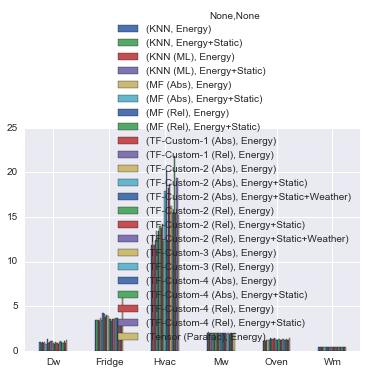

In [43]:
%matplotlib inline
out.T.plot(kind="bar",rot=0)

In [44]:
appliance='hvac'
pred = knn_p[appliance][feature][neighbours]
gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)

In [45]:
print neighbours
pred = mf_p[appliance][feature]['relative'][neighbours]
gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)

6


In [46]:
e[e>50]

hvac_6  4297     69.209
hvac_8  5109    162.120
dtype: float64

In [47]:
pred.ix[7641]

KeyError: 7641

In [ ]:
gt_f.ix[7641]

In [ ]:
pred_f[pred_f>60].unstack().dropna()

In [ ]:
from mf_core import *

import numpy as np
import pandas as pd
import sys
from create_matrix import *
from sklearn.model_selection import LeaveOneOut
from scipy.optimize import nnls

import pickle
from tensor_custom_core import *


APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

def un_normalize(x, maximum, minimum):
    return (maximum-minimum)*x + minimum


a, b = 3, 3

print a, b


pred = {}
for appliance in APPLIANCES[:1]:
    pred[appliance] = {}
    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    months = stop - start
    pred[appliance] = {}
    appliance_df = create_matrix_all_entries(region, year, appliance)
    aggregate_cols = [x for x in appliance_df.columns if "aggregate" in x]
    appliance_cols = [x for x in appliance_df.columns if appliance in x]
    energy_cols = np.concatenate([aggregate_cols, appliance_cols])

    df = appliance_df.copy()

In [ ]:
df.columns[-3:]

In [ ]:
static_cols = ['area', 'total_occupants', 'num_rooms']
static_df = df[static_cols]
static_df = static_df.div(static_df.max())

In [ ]:
static_df

In [ ]:
weather_df = np.ones(len(static_df)).reshape(-1, 1)

In [ ]:
weather_df